In [23]:
import pandas as pd
import gensim
from nltk.corpus import stopwords
import tqdm
import nltk
import string
from sklearn.feature_extraction.text import TfidfVectorizer
import pymorphy2
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv('./data/train_task1_latest.csv')
w2v = gensim.models.KeyedVectors.load_word2vec_format('./w2v/ruwikiruscorpora_0_300_20.bin',binary=True)

Токенизация в "обогащенный" формат rusvectores

In [4]:
rem = stopwords.words('russian') + list(string.punctuation)+list('—')
ma = pymorphy2.MorphAnalyzer()
d = {} # Словарь для ускорения преобразований
grammar_map_POS_TAGS = {
    'NOUN': '_NOUN',
    'VERB': '_VERB', 'INFN': '_VERB', 'GRND': '_VERB', 'PRTF': '_VERB', 'PRTS': '_VERB',
    'ADJF': '_ADJ', 'ADJS': '_ADJ',
    'ADVB': '_ADV',
    'PRED': '_ADP'
}
for col in ['paragraph','question']:
    df = df.sort_values(by=col)
    prev_text = ''
    tokenised = []
    t = []
    for e in tqdm.tqdm(iter(df[col]),total=df.shape[0],desc='Tokenising '+col+'s'):
        if e == prev_text:
            tokenised.append(t)
        else:
            #t = nltk.word_tokenize(e.lower(),language='russian',preserve_line=False)
            t = nltk.regexp_tokenize(pattern='[а-яёa-z]+',text=e.lower())
            r = []
            for w in t:
                if w not in rem:
                    if not w in d.keys():
                        forms = ma.parse(w)
                        try:
                            form = max(forms, key=lambda x: (x.score, x.methods_stack[0][2]))
                            d[w] = form
                        except Exception:
                            form = forms[0]
                        nf = form.normal_form.replace("ё", "е") + grammar_map_POS_TAGS.get(form.tag.POS, '')
                        d[w] = nf
                    else:
                        nf = d[w]
                    r.append(nf)
            tokenised.append(r)
            t = r
            prev_text = e
    df[col+'_tk'] = tokenised
all_docs = list(df['paragraph_tk'])+list(df['question_tk'])
print('Done.')

Tokenising questions: 100%|██████████| 119398/119398 [00:02<00:00, 42197.35it/s]

Done.


Векторизация

In [6]:
d = {} # Словарь для ускорения преобразований
for col in ['paragraph_tk','question_tk']:
    vecs = []
    for t in tqdm.tqdm(iter(df[col]),total=df.shape[0],desc='Vectorizing '+col):
        v = []
        for k in t:
            if k in d:
                ret = d[k]
            else:
                ret = np.zeros(w2v.vector_size)  
                if k in w2v.vocab:
                    ret = w2v[k]
                    d[k] = ret
            v.append(ret) #= list(map(sum, zip(v,ret)))
        v_sum = np.sum(v,axis=0)
        norm = np.linalg.norm(v_sum,ord=1)
        if norm == 0:
            v_avg = np.zeros(w2v.vector_size)
        else:
            v_avg = v_sum/np.linalg.norm(v_sum,ord=1)
        vecs.append(v_avg)
    df[col+'_vec'] = vecs
print('Done.')

Vectorizing question_tk: 100%|██████████| 119398/119398 [00:04<00:00, 24072.26it/s]

Done.


Считаем расстояния

In [22]:
from scipy import spatial

cosine = []
braycurtis = []
canberra = []
chebyshev = []
manhatten = []
correlation = []
euclidian = []
minkowski =[]

for i,r in tqdm.tqdm(df.iterrows(),total=df.shape[0],desc='Calculating measures'):
    a = r['paragraph_tk_vec']
    b = r['question_tk_vec']
    cosine.append(spatial.distance.cosine(a,b))
    braycurtis.append(spatial.distance.braycurtis(a,b))
    canberra.append(spatial.distance.canberra(a,b))
    chebyshev.append(spatial.distance.chebyshev(a,b))
    manhatten.append(spatial.distance.cityblock(a,b))
    correlation.append(spatial.distance.correlation(a,b))
    euclidian.append(spatial.distance.euclidean(a,b))
    minkowski.append(spatial.distance.minkowski(a,b,3))
    
df['dist_cosine'] = cosine
df['dist_braycurtis'] = braycurtis
df['dist_canberra'] = canberra
df['dist_chebyshev'] = chebyshev
df['dist_manhatten'] = manhatten
df['dist_correlation'] = correlation
df['dist_euclidian'] = euclidian
df['dist_minkowski'] = minkowski
print('Done.')

Calculating measures:   0%|          | 2/119398 [00:00<1:39:53, 19.92it/s]/Users/sermolov/anaconda/lib/python3.6/site-packages/scipy/spatial/distance.py:505: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - np.dot(u, v) / (norm(u) * norm(v))
/Users/sermolov/anaconda/lib/python3.6/site-packages/scipy/spatial/distance.py:543: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - np.dot(um, vm) / (norm(um) * norm(vm))
Calculating measures: 100%|██████████| 119398/119398 [00:42<00:00, 2778.51it/s]


Done.


Визуализируем

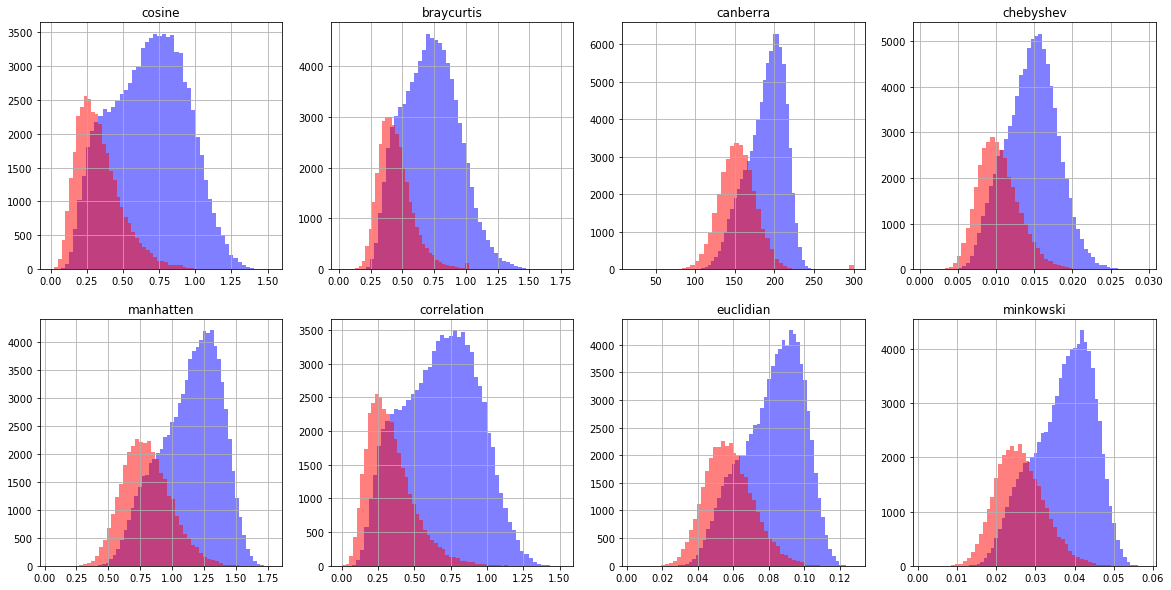

In [50]:
fig, axes = plt.subplots(2, 4, figsize=(20,10))
for i,mn in enumerate(['cosine','braycurtis','canberra','chebyshev','manhatten','correlation','euclidian','minkowski']):
    r = int(i/4)
    c = i%4
    df[df['target']==0]['dist_'+mn].hist(ax = axes[r,c],color='b',alpha=0.5,bins=50)
    df[df['target']==1]['dist_'+mn].hist(ax = axes[r,c],color='r',alpha=0.5,bins=50)
    axes[r,c].set_title(mn)
plt.show()
